# Chapter 4 - Testing a causal DAG with functional constraints

The notebook is a code companion to chapter 4 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%204/Testing_a_causal_DAG_with_functional_constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Using pgmpy 0.1.19 because versions 0.1.20 - 0.1.24 (current at time of writing) have a bug that prevents this code from running. An issue has been created on Github.
# For stability, I also use the version of pandas that was available when pgmpy 0.1.19 was available.
!pip install pgmpy==0.1.19
!pip install pandas==1.4.3

In this tutorial, we illustrate how to falsify a causal DAG using a functional constraint called a Verma constraints. Verma constraints are like conditional independence constraints -- they are a type of contraint on the joint probability of the observed variables in your model that holds assuming your DAG is correct. But to test a conditional independence constraint, you need to observe all the variables involved in the constraint. Verma constraints are constraints you can test when there are latent variables.

We look at the following model:

![verma_DAG](https://github.com/altdeep/causalML/blob/master/book/chapter%204/images/verma_DAG.png?raw=1)

This DAG implies the following conditional independencies:

* S ⊥ L | D, T
* T ⊥ C | S
* T ⊥ D | S
* L ⊥ C | D, S
* L ⊥ C | D, T
* C ⊥ D

These are six conditional independence constraints that we can test. But let's assume genetics (D) is unobserved. Then we can only test T ⊥ C | S. However, the following Verma constraint involving the observed variables is:

$h(L, T, C) \perp C$ where $h(l, t, c) = \sum_{S=s} P(L=l|C=c, S=s, T=t) P(S=s|C=c)$

So in this tutorial, for each row's values of l, s, t, c, we calculate h(L, T, C), then test this quantities independence relative to C.

First, I'll load the data discretize C to make things easier. With this discretization we will lose some bit of information, but again, the goal is to test our DAG, rather than achieving some ideal level of mathematical precision.

In [ ]:
from functools import partial
import numpy as np
import pandas as pd

data_url = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/cigs_and_cancer.csv"
data = pd.read_csv(data_url)    #A
cost_lower = np.quantile(data["C"], 1/3)    #B
cost_upper = np.quantile(data["C"], 2/3)    #B
def discretize_three(val, lower, upper):    #B
   if val < lower:    #B
       return "Low"    #B
   if val < upper:    #B
       return "Med"    #B
   return "High"    #B

data_disc = data.assign(    #B
   C = lambda df: df['C'].map(    #B
           partial(    #B
               discretize_three,    #B
               lower=cost_lower,    #B
               upper=cost_upper    #B
           )    #B
       )    #B
)    #B
data_disc = data_disc.assign(    #C
   L = lambda df: df['L'].map(str),    #C
)    #C
print(data_disc)

#A Load the csv into a Panda data frame.
#B Discretize cost (C) into a discrete variable with three levels to facilitate conditional impendence tests.
#C Turn lung cancer (L) from a Boolean to a string, so the conditional independence test will treat it as a discrete variable.


       C     S     T      L
0   High   Med   Low   True
1    Med  High  High  False
2    Med  High  High   True
3    Med  High  High   True
4    Med  High  High   True
..   ...   ...   ...    ...
95   Low  High  High   True
96  High  High  High  False
97   Low   Low   Low  False
98  High   Low   Low  False
99   Low  High  High   True

[100 rows x 4 columns]


First, we use a naive Bayes classifier to model the distributions P(L=l|C=c, S=s, T=t) and P(S=s|C=c), the two components of the function g(l, c, s, t).

In [ ]:
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import NaiveBayes

model_L_given_CST = NaiveBayes()    #A
model_L_given_CST.fit(data_disc, 'L', estimator=BayesianEstimator)    #A
infer_L_given_CST = VariableElimination(model_L_given_CST)    #A

def p_L_given_CST(L_val, C_val, S_val, T_val, engine=infer_L_given_CST): #A

   result_out = engine.query(    #A
       variables=["L"],    #A
       evidence={'C': C_val, 'S': S_val, 'T': T_val},    #A
       show_progress=False    #A
   )    #A
   prob = dict(zip(result_out.state_names["L"], result_out.values))    #A
   return prob[L_val]    #A
#A We’ll use a naïve Bayes classifier in pgmpy to calculate the probability value for a given value of L given values of C, S, and T. In this case I use variable elimination.

Simulating results for L=True, C=Low, S=Low, and T=Low.

In [ ]:
p_L_given_CST("True", "Low", "Low", "Low")

0.6173631165455108

In [ ]:
model_S_given_C = NaiveBayes()    #A
model_S_given_C.fit(data_disc, 'S', estimator=BayesianEstimator)    #A

infer_S_given_C = VariableElimination(model_S_given_C)    #A
def p_S_given_C(S_val, C_val, engine=infer_S_given_C):    #A
    result_out = engine.query(    #A
       variables=['S'],    #A
       evidence={'C': C_val},    #A
       show_progress=False    #A
   )    #A
   prob = dict(zip(result_out.state_names["S"], result_out.values))    #A
   return prob[S_val]    #A
#A Fit a naïve Bayes classifier of P(S|C)

Next, I implement the h(.) function.

In [ ]:
def h_function(L, C, T):    #A
    summ = 0    #B
    for s in ["Low", "Med", "High"]:    #B
        summ += p_L_given_CST(L, C, s, T) * p_S_given_C(s, C)    #B
    return summ

#A Implement h(L, C, T)
#B Implement summation of P(l|c,s,t) * P(s|c) over s

Next, we'll enumerate all combinations of C, T, and L so that we can calculate h(C, L, T) one each of these combinations.

In [ ]:
ctl_outcomes = pd.DataFrame(
    [    #A
        (C, T, L)    #A
        for C in ["Low", "Med", "High"]    #A
        for T in ["Low", "High"]    #A
        for L in ["False", "True"]    #A
    ],    #A
    columns = ['C', 'T', 'L']    #A
)
#A Now I'll calculate these values for each possible combination of outcomes of L, C, and T. First, I use list comprehensions to make a data frame containing all the combinations.

In [ ]:
print(ctl_outcomes)

       C     T      L
0    Low   Low  False
1    Low   Low   True
2    Low  High  False
3    Low  High   True
4    Med   Low  False
5    Med   Low   True
6    Med  High  False
7    Med  High   True
8   High   Low  False
9   High   Low   True
10  High  High  False
11  High  High   True


Next for each combination of {L, C, T} in the dataset, we'll get values of h(L=l, C=c, T=t).

In [ ]:
h_dist = ctl_outcomes.assign(    #A
    h_func = ctl_outcomes.apply(    #A
        lambda row: h_function(    #A
            row['L'], row['C'], row['T']), axis = 1    #A
    )    #A
)    #A
print(h_dist)
# Calculate h(L, C, T) for each combination.

       C     T      L    h_func
0    Low   Low  False  0.399869
1    Low   Low   True  0.600131
2    Low  High  False  0.264353
3    Low  High   True  0.735647
4    Med   Low  False  0.523694
5    Med   Low   True  0.476306
6    Med  High  False  0.373653
7    Med  High   True  0.626347
8   High   Low  False  0.496355
9   High   Low   True  0.503645
10  High  High  False  0.348536
11  High  High   True  0.651464


Finally, we join the sum-product back on the data, so we have its value for each row of the data.

In [ ]:
df_mod = data_disc.merge(h_dist, on=['C', 'T', 'L'], how='left')    #A
print(df_mod)
# Add a column representing the variable h(C, T, L)

       C     S     T      L    h_func
0   High   Med   Low   True  0.503645
1    Med  High  High  False  0.373653
2    Med  High  High   True  0.626347
3    Med  High  High   True  0.626347
4    Med  High  High   True  0.626347
..   ...   ...   ...    ...       ...
95   Low  High  High   True  0.735647
96  High  High  High  False  0.348536
97   Low   Low   Low  False  0.399869
98  High   Low   Low  False  0.496355
99   Low  High  High   True  0.735647

[100 rows x 5 columns]


To visualize independence of this quantity with C, we can use a boxplot.

<Axes: title={'center': 'h_func'}, xlabel='C'>

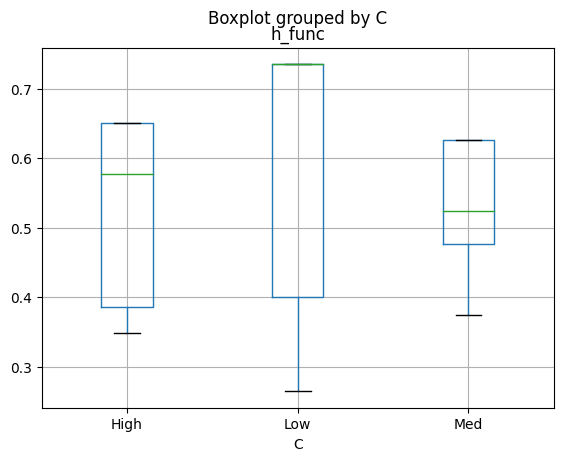

In [ ]:
df_mod.boxplot("h_func", "C")

The overlap of the boxes indicates independence.

We can also use an [F-test](https://en.wikipedia.org/wiki/F-test) to test independence. The null hypothesis is independence. Let's assume a typical significance threshold of .1. A p-value below the threshold means one should reject the null hypothesis and favor the conclusion of dependence. That doesn't happen in this case.

In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols('h_func ~ C', data=df_mod).fit()    #A
aov_table = sm.stats.anova_lm(model, typ=2)    #A
aov_table["PR(>F)"]["C"]    #A

0.19364363417824296

As a sanity check, we can test independence with T and L. These have small p-values that fall below a .1 significance threshold.

In [ ]:
model = ols('h_func ~ T', data=df_mod).fit()    #B
aov_table = sm.stats.anova_lm(model, typ=2)    #B
aov_table["PR(>F)"]["T"]    #B

0.07522736142622224

In [ ]:
model = ols('h_func ~ L', data=df_mod).fit()    #C
aov_table = sm.stats.anova_lm(model, typ=2)    #C
aov_table["PR(>F)"]["L"]    #C

7.054785247783987e-28